In [3]:
# Corrected Data Preparation
import torch
from transformers import AutoTokenizer
from datasets import load_dataset

# Load and tokenize dataset
dataset = load_dataset('glue', 'sst2')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['sentence'],
                   padding='max_length',
                   truncation=True,
                   max_length=64)

# Tokenize and remove text columns
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['sentence', 'idx']
)

# Split dataset
train_holdout = tokenized_datasets['train'].train_test_split(test_size=0.2, seed=42)

# Add index ONLY to training data
train_ds = train_holdout['train'].add_column('index', list(range(len(train_holdout['train']))))
holdout_ds = train_holdout['test']
val_ds = tokenized_datasets['validation']

# Set formats SEPARATELY
train_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'label', 'index'])
holdout_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Create dataloaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=batch_size)
holdout_loader = torch.utils.data.DataLoader(holdout_ds, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/53879 [00:00<?, ? examples/s]

In [4]:
import torch.nn as nn
from transformers import BertConfig, BertModel

class UltraCompactTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        config = BertConfig(
            hidden_size=72,
            num_hidden_layers=2,
            num_attention_heads=2,
            intermediate_size=144,
            max_position_embeddings=64
        )
        self.bert = BertModel(config)
        self.classifier = nn.Linear(72, 2)

        # Freeze embeddings to save parameters
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.classifier(outputs.last_hidden_state[:, 0])

# Verify parameters
model = UltraCompactTransformer()
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")  # Should output ~148,000

Trainable parameters: 89,930


In [5]:
def train_il_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    il_model = UltraCompactTransformer().to(device)
    optimizer = torch.optim.AdamW(il_model.parameters(), lr=2e-4)
    criterion = nn.CrossEntropyLoss()

    # Train IL model
    il_model.train()
    for epoch in range(3):
        for batch in holdout_loader:
            inputs = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = il_model(inputs, mask)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Compute IL values
    il_model.eval()
    il_values = torch.zeros(len(train_ds))

    with torch.no_grad():
        il_loader = torch.utils.data.DataLoader(
            train_ds,
            batch_size=batch_size,
            shuffle=False
        )
        for batch in il_loader:
            inputs = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            indices = batch['index']

            outputs = il_model(inputs, mask)
            losses = nn.functional.cross_entropy(outputs, labels, reduction='none')
            il_values[indices] = losses.cpu()

    return il_values

il_tensor = train_il_model()

In [6]:
def rho_loss_training():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UltraCompactTransformer().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(10):
        # Training
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            inputs = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            indices = batch['index'].to(device)

            # Compute current losses
            with torch.no_grad():
                outputs = model(inputs, mask)
                current_losses = nn.functional.cross_entropy(outputs, labels, reduction='none')

            # Get IL values for this batch
            batch_il = il_tensor[indices.cpu()].to(device)

            # Calculate reducible loss
            reducible_loss = current_losses - batch_il

            # Select top-k samples
            k = min(batch_size, reducible_loss.size(0))
            _, selected_indices = torch.topk(reducible_loss, k)

            # Train on selected samples
            outputs = model(inputs[selected_indices], mask[selected_indices])
            loss = criterion(outputs, labels[selected_indices])

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['input_ids'].to(device)
                mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(inputs, mask)
                val_loss += criterion(outputs, labels).item()

        # Save losses
        train_losses.append(epoch_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

# Start training
train_loss, val_loss = rho_loss_training()

Epoch 1: Train Loss: 0.6829, Val Loss: 0.6809
Epoch 2: Train Loss: 0.6660, Val Loss: 0.6637
Epoch 3: Train Loss: 0.6549, Val Loss: 0.6653
Epoch 4: Train Loss: 0.6469, Val Loss: 0.6517
Epoch 5: Train Loss: 0.6428, Val Loss: 0.6462
Epoch 6: Train Loss: 0.6362, Val Loss: 0.6388
Epoch 7: Train Loss: 0.6323, Val Loss: 0.6314
Epoch 8: Train Loss: 0.6296, Val Loss: 0.6320
Epoch 9: Train Loss: 0.6262, Val Loss: 0.6275
Epoch 10: Train Loss: 0.6242, Val Loss: 0.6233


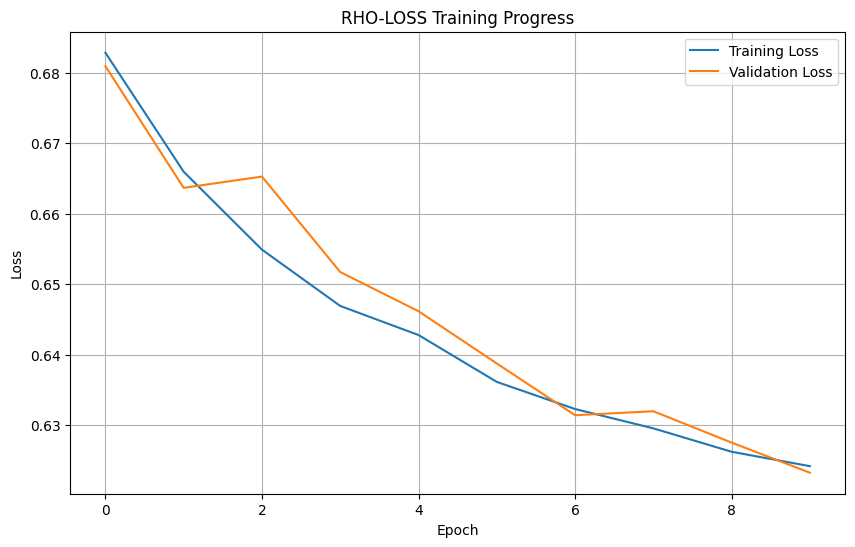

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RHO-LOSS Training Progress')
plt.legend()
plt.grid(True)
plt.show()